# Libraries

In [48]:
import os
from pathlib import Path
import shutil

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

# Load Data

In [2]:
for dirname,subdirs,filenames in os.walk('/kaggle/input/'):
    print(f'Directory:{dirname}')
    for subdir in subdirs:
        print(f'  subdircotry:{subdir}')
    #for filename in filenames:
     #   print(f'  subdircotry:{filename}')

Directory:/kaggle/input/
  subdircotry:covid19-radiography-database
Directory:/kaggle/input/covid19-radiography-database
  subdircotry:COVID-19_Radiography_Dataset
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset
  subdircotry:Normal
  subdircotry:Lung_Opacity
  subdircotry:Viral Pneumonia
  subdircotry:COVID
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal
  subdircotry:images
  subdircotry:masks
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity
  subdircotry:images
  subdircotry:masks
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images
Directory:/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/ma

In [ ]:
from pathlib import Path

n = Path("COVID-19_Radiography_Dataset/Normal/images")
l = Path("COVID-19_Radiography_Dataset/Lung_Opacity/images")
v = Path("COVID-19_Radiography_Dataset/Viral Pneumonia/images")
c = Path("covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images")

image_dirs = {
    "Normal": n,
    "Lung Opacity": l,
    "Viral Pneumonia": v,
    "COVID": c
}

for label, image_dir in image_dirs.items():
    if image_dir.exists():
        file_count = len(list(image_dir.glob('*')))  # Count the number of files
        print(f"{file_count} for {label}")
 



10192 for Normal
6012 for Lung Opacity
1345 for Viral Pneumonia
1345 for COVID


In [ ]:
# Define paths for each class
n = Path("COVID-19_Radiography_Dataset/Normal/images")
l = Path("COVID-19_Radiography_Dataset/Lung_Opacity/images")
v = Path("COVID-19_Radiography_Dataset/Viral Pneumonia/images")
c = Path("COVID-19_Radiography_Dataset/COVID/images")

# Define the target directory to store the organized images
target_dir = "working/organized_data"

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Function to organize images by class
def organize_images(source_dir, class_name):
    class_dir = os.path.join(target_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    for file in source_dir.glob("*"):
        shutil.copy(file, class_dir)

# Organize images for each class
organize_images(n, 'Normal')
organize_images(l, 'Lung_Opacity')
organize_images(v, 'Viral_Pneumonia')
organize_images(c, 'COVID')



# Processing the data

In [17]:
# Define the dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    target_dir,
    image_size=(224, 224),
    batch_size=64,  
    seed=42
)


# calculate dataset sizes
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.2 * dataset_size)    # 20% for validation
test_size = dataset_size - train_size - val_size  # Remaining 10% for testing

# split the dataset
train_dataset = dataset.take(train_size)  # Take the first 70%
remaining = dataset.skip(train_size)      # Skip the first 70%
val_dataset = remaining.take(val_size)    # Take the next 20%
test_dataset = remaining.skip(val_size)   # The remaining 10%

train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache()
test_dataset = test_dataset.cache()

print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Test batches: {len(test_dataset)}")


Found 21165 files belonging to 4 classes.
Training batches: 231
Validation batches: 66
Test batches: 34


# Visualizing data

In [18]:
for images, labels in train_dataset.take(1):
    print(images.shape)  # (batch_size, image_height, image_width, channels)
    print(labels.numpy())  # (batch_size,)


(64, 224, 224, 3)
[1 2 0 1 0 0 0 1 0 1 0 0 2 2 1 1 2 2 2 3 2 2 2 2 2 3 2 2 1 2 1 2 1 2 1 2 2
 2 3 2 0 1 2 2 2 1 2 2 2 2 0 3 2 1 2 0 2 2 3 2 0 0 2 0]


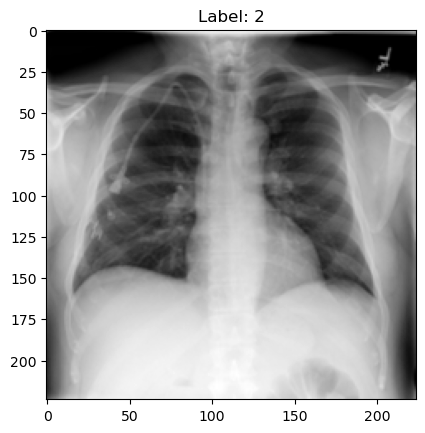

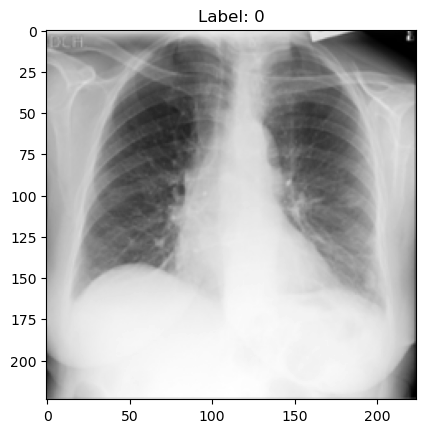

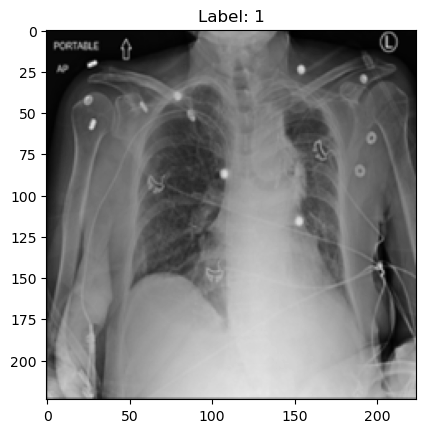

In [7]:
for img, label in train_dataset.unbatch().take(3):
    img_gray = tf.image.rgb_to_grayscale(img)  # Convert to grayscale
    img_gray = img_gray.numpy()
    plt.imshow(img_gray.squeeze(), cmap="gray")  
    plt.title(f"Label: {label.numpy()}")
    plt.show()

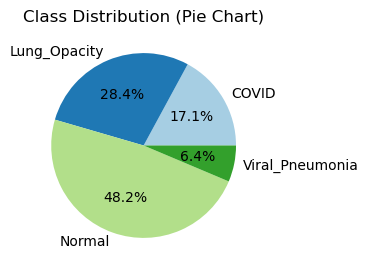

In [8]:
class_names = dataset.class_names

class_counts = {class_name: 0 for class_name in class_names}

for images, labels in dataset.unbatch():
    label = labels.numpy()
    class_counts[class_names[label]] += 1

plt.figure(figsize=(3, 3))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title("Class Distribution (Pie Chart)")
plt.show()


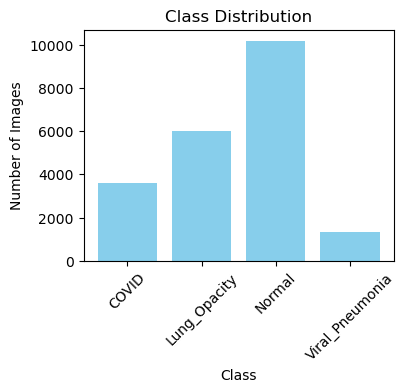

In [9]:
class_names = dataset.class_names

class_counts = {class_name: 0 for class_name in class_names}

for images, labels in dataset.unbatch():
    label = labels.numpy()
    class_counts[class_names[label]] += 1

plt.figure(figsize=(4, 3))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


# Using EfficientNetB0 Architecture

In [47]:
# Load EfficientNet base model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='max'  # Use global max pooling
)

base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),  
    Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4), 
    Dense(4, activation='softmax')  
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,679 (16.73 MB)

 Trainable params: 332,036 (1.27 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('efficientnet_best_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=7,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Epoch 1/7


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

# Evaluate model 1
**Here happened overfitting** 

In [38]:

train_score = model.evaluate(train_dataset,verbose= 1)
valid_score = model.evaluate(val_dataset,verbose= 1)
test_score = model.evaluate(test_dataset,verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

231/231 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.9432 - loss: 0.5585
66/66 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9091 - loss: 0.6732
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8924 - loss: 0.7288
Train Loss:  0.5600191354751587
Train Accuracy:  0.9432494640350342
--------------------
Validation Loss:  0.6876766681671143
Validation Accuracy:  0.904356062412262
--------------------
Test Loss:  0.7300785779953003
Test Accuracy:  0.8845618963241577


# Added augmentation layers 
**This helps the model generalize better**

In [49]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Using EfficientNetB0 with unfreeze last 20 layers

In [50]:
# Load EfficientNet base model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='max'  
)

base_model.trainable = True
for layer in base_model.layers[:-7]:  # Freeze all but the last 20 layers
    layer.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(), 
    Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.02)),
    BatchNormalization(),
    Dropout(0.5),  
    Dense(4, activation='softmax') 
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,679 (16.73 MB)

 Trainable params: 1,113,476 (4.25 MB)

 Non-trainable params: 3,271,203 (12.48 MB)

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('efficientnet_best_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 781s 3s/step - accuracy: 0.6302 - loss: 8.2431 - val_accuracy: 0.7625 - val_loss: 4.7216 - learning_rate: 0.0010
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 753s 3s/step - accuracy: 0.7684 - loss: 4.1700 - val_accuracy: 0.8203 - val_loss: 2.6169 - learning_rate: 0.0010
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 746s 3s/step - accuracy: 0.8008 - loss: 2.4003 - val_accuracy: 0.8205 - val_loss: 1.6541 - learning_rate: 0.0010
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step - accuracy: 0.8236 - loss: 1.5088 - val_accuracy: 0.8468 - val_loss: 1.0843 - learning_rate: 0.0010
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 3039s 13s/step - accuracy: 0.8335 - loss: 1.0255 - val_accuracy: 0.8201 - val_loss: 0.8615 - learning_rate: 0.0010
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1036s 4s/step - accuracy: 0.8439 - loss: 0.7719 - val_accuracy: 0.8265 - val_loss: 0.7215 - learning_rate: 0.0010
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 639s 3s/step - accuracy: 0.8448 - loss:

# Evaluate model 2

In [52]:
train_score = model.evaluate(train_dataset,verbose= 1)
valid_score = model.evaluate(val_dataset,verbose= 1)
test_score = model.evaluate(test_dataset,verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

231/231 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.8830 - loss: 0.4271
66/66 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8580 - loss: 0.4958
34/34 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8617 - loss: 0.4974
Train Loss:  0.43050727248191833
Train Accuracy:  0.8825757503509521
--------------------
Validation Loss:  0.4880353808403015
Validation Accuracy:  0.8617424368858337
--------------------
Test Loss:  0.5109795331954956
Test Accuracy:  0.8562818765640259


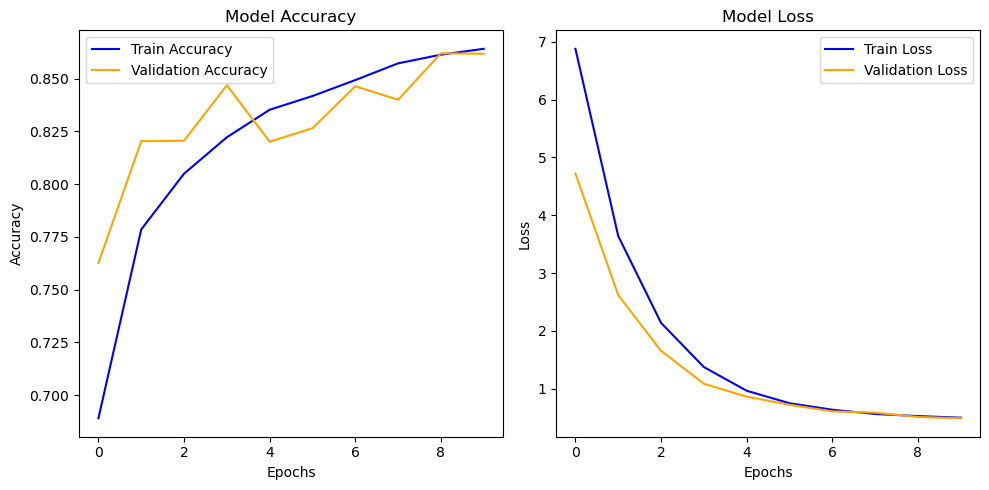

In [53]:
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Classification Report

In [54]:
y_pred_probs = model.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

print("Classification Report:\n")
print(classification_report(y_true, y_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step
Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.87      0.79       362
           1       0.86      0.84      0.85       626
           2       0.90      0.87      0.88      1013
           3       0.91      0.82      0.86       156

    accuracy                           0.86      2157
   macro avg       0.85      0.85      0.85      2157
weighted avg       0.86      0.86      0.86      2157



# Confusion Matrics

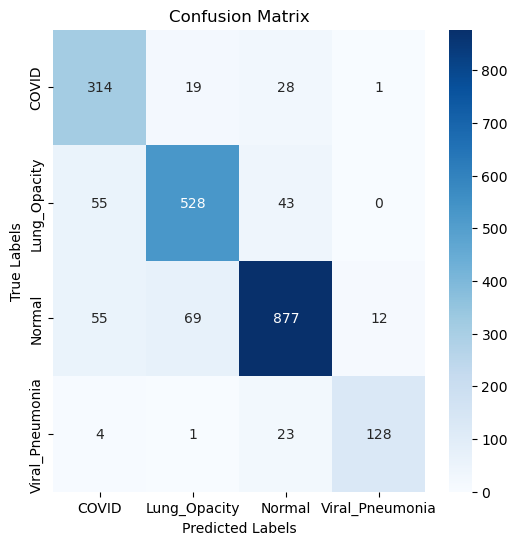

In [59]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Get Predictions

In [60]:
y_pred_probs = model.predict(test_dataset)  
y_pred = np.argmax(y_pred_probs, axis=1)  
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true

34/34 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step


array([0, 2, 1, ..., 0, 1, 1])

# Save model

In [18]:
subject = 'Covid-19'
model_name = 'efficientnet'
acc = test_score[1] * 100  

# Define the save path
save_path = '/kaggle/working'  

# Save the entire model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.keras')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'Model was saved as {model_save_loc}')

# Save only the weights (with the correct filename format)
weight_save_id = str(f'{model_name}-{subject}-weights.weights.h5')  # Use .weights.h5
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'Weights were saved as {weights_save_loc}')

Model was saved as /kaggle/working\efficientnet-Covid-19-88.46.keras
Weights were saved as /kaggle/working\efficientnet-Covid-19-weights.weights.h5


**Generate CSV files containing classes indicies & image size**

In [63]:
model.save("covid1.h5")